# Navie Bayes Classifier - CA2 - AI

## importing libraries

In [38]:
import pandas as pd
from __future__ import unicode_literals
from hazm import *
import collections
from math import log
import matplotlib.pyplot as plt

## Loading train data

In [39]:
df = pd.read_csv("divar_train.csv")

## Normalization on train data

In [40]:
STOP_WORDS = ['از','که','با','به','برای','را','تا','اگه','اگر','اما','در', 'و', 'هر']

stemmer = Stemmer()
lemmatizer = Lemmatizer()
def _normalize(s):
    words = word_tokenize(s)
    for index, word in enumerate(words):
        words[index] = stemmer.stem(word)
        words[index] = lemmatizer.lemmatize(word)
    return list(filter(lambda word: word not in STOP_WORDS and len(word) != 1, words))

df['description'] = df['description'].apply(_normalize)
df['title'] = df['title'].apply(_normalize)

## Training model

In [41]:
words_count_per_category = {}
def mapping(df):
    category_words_list = []
    df['title'].apply(lambda l: category_words_list.extend(l))
    df['description'].apply(lambda l: category_words_list.extend(l)) 
    word_to_count_map = collections.Counter(category_words_list)
    category_name = df.iloc[0]['categories']
    words_count_per_category[category_name] = word_to_count_map

df.groupby('categories').apply(mapping)

p_c = collections.Counter(df['categories'])
p_c = dict(map(lambda p: (p[0],p[1]/df.shape[0]), p_c.items()))

def get_cond_prob(word, word_to_count_map):
    all_words = sum(word_to_count_map.values())
    if word not in word_to_count_map: return 0.000000001
    return word_to_count_map[word] / all_words

def get_cond_prob_AS(word, word_to_count_map):
    all_words = sum(word_to_count_map.values())
    all_keys = len(word_to_count_map.keys())
    if word not in word_to_count_map:
        return 1 / (all_words+all_keys+1)
    return ((word_to_count_map[word]+1) / (all_words+all_keys+1))

## Ploting

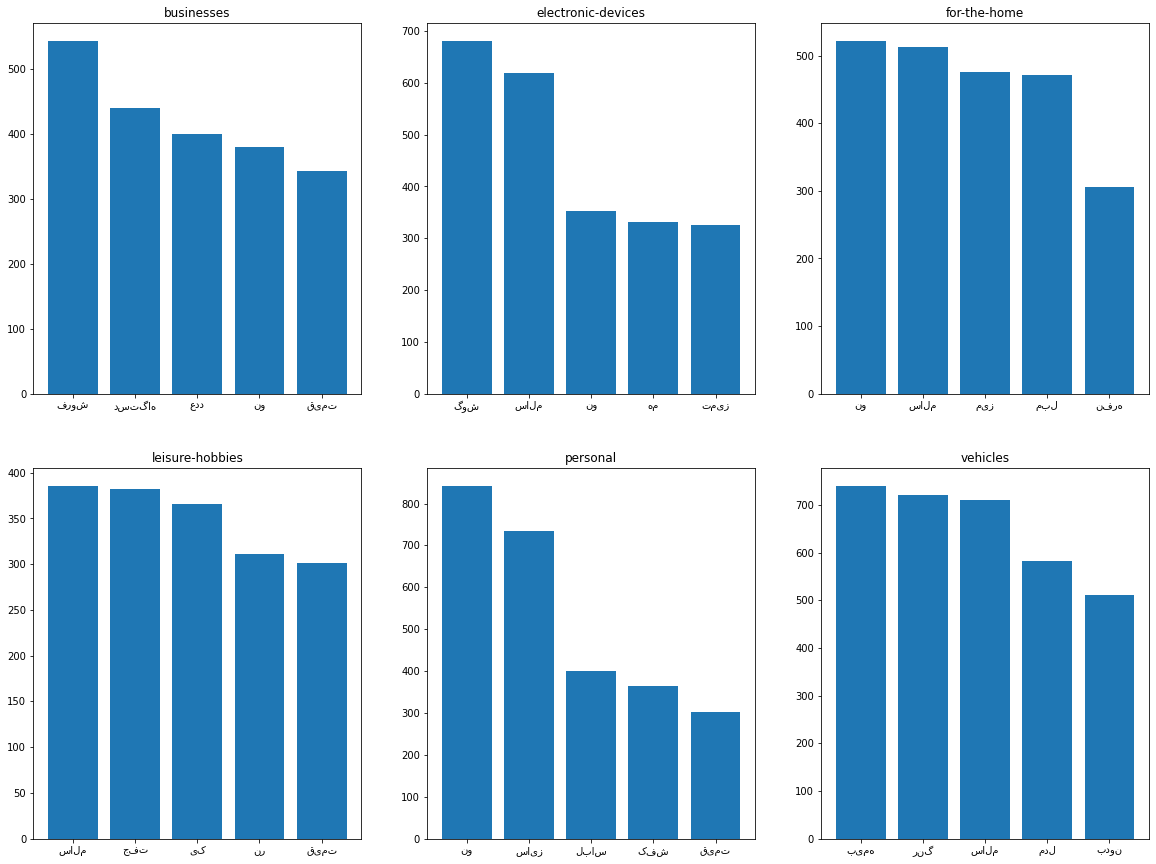

In [42]:
fig, axs = plt.subplots(2, 3, figsize=(20,15))

for index, category in enumerate(words_count_per_category.keys()):
    axs[int(index/3), int(index%3)].bar(dict(words_count_per_category[category].most_common(5)).keys(),
                                dict(words_count_per_category[category].most_common(5)).values())
    axs[int(index/3), int(index%3)].set_title(category)


## Testing

### Loading test data and normalizing it

In [43]:
test_df = pd.read_csv('divar_test.csv')
test_df['description'] = test_df['description'].apply(_normalize)
test_df['title'] = test_df['title'].apply(_normalize)

### Implementting classifiers

In [44]:
# without smoothing
def classifier1(X):
    category_likelihood = {}
    for category, c_prob in p_c.items():
        prob = log(c_prob)
        for word in X:
            if word not in words_count_per_category[category]:
                prob = float('-inf')
                break
            prob += log(get_cond_prob(word, words_count_per_category[category]))
        category_likelihood[category] = prob
    return max(category_likelihood, key = category_likelihood.get)

#with smoothing
def classifier2(X):
    category_likelihood = {}
    for category, c_prob in p_c.items():
        prob = log(c_prob)
        for word in X:
            prob += log(get_cond_prob_AS(word, words_count_per_category[category]))
        category_likelihood[category] = prob
    return max(category_likelihood, key = category_likelihood.get)

predicted1 = []
predicted2 = []
for row in test_df.iloc:
    words_of_sample = row['title'].copy()
    words_of_sample.extend(row['description'])
    predicted1.append((row['categories'], classifier1(words_of_sample)))
    predicted2.append((row['categories'], classifier2(words_of_sample)))


## Metric funtions

In [45]:
def accuracy(predicted):
    return 100 * sum(1 for tup in predicted if tup[0]==tup[1]) / len(predicted)

def precision(predicted, category):
    return 100 * sum(1 for tup in predicted if tup[1]==category and tup[0]==tup[1]) / sum(1 for tup in predicted if tup[1]==category)

def recall(predicted, category):
    return 100 * sum(1 for tup in predicted if tup[1]==category and tup[0]==tup[1]) / sum(1 for tup in predicted if tup[0]==category)

def F1(predicted, category):
    pre = precision(predicted, category)
    rec = recall(predicted, category)
    return  2 * ((pre * rec) / (pre+rec))

def macro_avg(values):
    return sum(values) / len(values)

def weighted_avg(values, weights):
    return sum(x[0] * x[1] for x in zip(values, weights)) / sum(weights)

def micro_avg(predicted):
    micro_pre = accuracy(predicted)
    micro_rec = accuracy(predicted)
    return 2 * ((micro_pre * micro_rec) / (micro_pre+micro_rec))


### Evaluation

In [46]:
def evalute_category_base(predicted):
    precision_values, recall_values, f1_values = [], [], []
    for category in p_c.keys():
        print(category, ':')
        value = precision(predicted, category)
        print('precision: %.2f' % (value))
        precision_values.append(value)

        value = recall(predicted, category)
        print('recall: %.2f' % (value))
        recall_values.append(value)

        value = F1(predicted, category)
        print('F1: %.2f' % (value))
        f1_values.append(value)
        print(15*'-')
    return precision_values, recall_values, f1_values

def evalute_overall(predicted):
    precision_values, recall_values, f1_values = evalute_category_base(predicted)
    print('**all classes:')
    print('accuracy: %.2f' % (accuracy(predicted)))
    print('macro avg F1: %.2f' % (macro_avg(f1_values)))
    print('micro avg F1: %.2f' % (micro_avg(predicted)))
    print('weighted avg F1: %.2f' % (weighted_avg(f1_values, [int(df.shape[0]*prob) for prob in p_c.values()])))


print('*****without additive smoothing:')
evalute_overall(predicted1)
print('\n\n*****with additive smoothing:')
evalute_overall(predicted2)

*****without additive smoothing:
leisure-hobbies :
precision: 22.55
recall: 98.00
F1: 36.66
---------------
vehicles :
precision: 94.32
recall: 27.67
F1: 42.78
---------------
for-the-home :
precision: 86.05
recall: 37.00
F1: 51.75
---------------
personal :
precision: 91.59
recall: 32.67
F1: 48.16
---------------
electronic-devices :
precision: 88.52
recall: 18.00
F1: 29.92
---------------
businesses :
precision: 76.58
recall: 28.33
F1: 41.36
---------------
**all classes:
accuracy: 40.28
macro avg F1: 41.77
micro avg F1: 40.28
weighted avg F1: 41.77


*****with additive smoothing:
leisure-hobbies :
precision: 92.51
recall: 82.33
F1: 87.13
---------------
vehicles :
precision: 94.37
recall: 89.33
F1: 91.78
---------------
for-the-home :
precision: 76.55
recall: 90.33
F1: 82.87
---------------
personal :
precision: 87.06
recall: 89.67
F1: 88.34
---------------
electronic-devices :
precision: 91.84
recall: 90.00
F1: 90.91
---------------
businesses :
precision: 79.11
recall: 77.00
F1: 7

### Q12

In [47]:
five_wrong_index = [i for i, v in enumerate(predicted2) if v[0] != v[1]][0:5]
five_wrong = test_df.loc[five_wrong_index, :].assign(pred = [predicted2[i][1] for i in five_wrong_index])
five_wrong

,title,description,categories,pred
16,[سیپوراکس],"[سیپوراکس, میکرو, مک, جی, بی, ال, سرامیک, سرا,...",leisure-hobbies,for-the-home
28,"[موتور, تزیین]","[جنس, اهن, کار, دست, عرضه, صورت, عمده, تک]",for-the-home,businesses
37,"[90, عدد, بشقاب, پیتزا, تک, نفره, قیمت, هرعدد,...","[بشقاب, پیتزا, یک, نفره, عدد, 4000, باتشکراز, ...",businesses,for-the-home
49,"[اچارشلاقی, HEYCOالمان]","[اصل, المان, سایز, ۱/۵, بسیار, مقاوم]",businesses,personal
50,"[فروش, تلفکس]","[سلام, تلفکس, پاناسونیک, تمیز, کم, کار]",businesses,electronic-devices
